# **Efficient Fine-Tuning Llama-v2-7b On Multi-Label Classification**

**Note: Run & view this notebook on `google colab`. Some of the outputs are either truncated or not generated on `visual studio code`.**

#### **Why LLaMA?**
In the ever-expanding digital landscape, the imperative for effective content moderation and toxicity classification has grown exponentially, necessitating advanced language models capable of nuanced understanding and efficient adaptation to evolving linguistic nuances. Within this context, LLaMa, Meta's cutting-edge Large Language Model, emerges as a compelling choice. LLaMa's prowess lies in its inherent ability to capture intricate semantic relationships and contextual nuances, making it particularly well-suited for discerning toxic content and mitigating moderation challenges. Furthermore, LLaMa's fine-tuning capabilities, coupled with its task-specific optimization, empower it to excel in toxicity classification tasks by efficiently adapting to the dynamic nature of online discourse. As the digital realm continues to grapple with content moderation imperatives, LLaMa stands out as a promising solution, offering a sophisticated blend of linguistic understanding and adaptability crucial for effective and responsible content management.
When it comes to training large language models, if we have a large dataset, we can in fact train a LLM from scratch. But as data limitation is a huge concern, since LLMs do require massive data, we then approach different techniques of using LLMs for our custom data such fine-tuning, Retreival Augmentation or General Model.



---


This codebook focuses on **Fine-Tuning** Llama - Language Model

Finetuning models such as Llama-60B is a very efficient way of fine-tuning a smaller model on a custom dataset that performs as good as the larger general model.

In this codebook, we will also be referring to **Declarative Machine Learning** in which the program learns pipelines by just a configuration file which contains about the scheme of the data, and data types. For Declarative Machine Learning, we will be using an open-source framework called, **"Ludwig"**

### **Ludwig Architecture**
Ludwig architecture makes it a very efficient framework because it accepts multiple inputs and produces multiple outputs of different data types, including binary, category, numerical, text, image, audio etc.

*  **Ludwig Architecture**: Flexibility and Ease of Fine-tuning
Ludwig is an open-source, flexible, and user-friendly framework for training and deploying deep learning models. Its architecture offers several advantages for fine-tuning, making it easier and more efficient than other frameworks.

*  **Key Architectural Features**:

  *  Modular and Component-based: Ludwig is built on a modular architecture, consisting of independent components for data loading, preprocessing, model building, training, and evaluation. This allows for easy replacement and customization of individual components, making it flexible for different tasks and adaptable to new research advancements.
  *  Declarative Model Definition: Ludwig utilizes a declarative YAML file to define the model architecture, hyperparameters, and training process. This approach simplifies model specification and avoids writing complex code, making it easier for users to experiment with different configurations and conduct fine-tuning.
  * Automatic Hyperparameter Tuning: Ludwig provides built-in support for automatic hyperparameter tuning, allowing users to optimize model performance without manually trying different combinations. This saves time and effort, especially when fine-tuning for specific datasets or tasks.
  * Transfer Learning and Fine-tuning: Ludwig seamlessly integrates transfer learning and fine-tuning capabilities. Pre-trained models can be readily imported and fine-tuned on custom datasets, enabling users to leverage existing knowledge and adapt models to specific requirements.
  * Scalability and Reproducibility: Ludwig supports distributed training on multiple GPUs and cloud platforms, enabling efficient training of complex models. Additionally, the declarative model definition ensures reproducibility of experiments and facilitates collaboration.
Benefits for Fine-tuning:

  * Reduced Development Time: The modularity and ease of configuration significantly reduce the time required to set up and fine-tune models.
  * Improved Experimentation: Declarative model definition and automated hyperparameter tuning facilitate rapid experimentation with different architectures and hyperparameters.
  * Faster Convergence: Efficient fine-tuning techniques, such as pre-trained models and fine-tuning specific layers, help models converge faster on new datasets.
  * Greater Flexibility: Ludwig is adaptable to diverse tasks and datasets, allowing for fine-tuning to specific needs and contexts.



### **Declarative Fine-Tune LLMs**

*   **Instruct Fine-Tuning**
  *   If you have a sequence (text) data and want a text as output as well Seq2Seq Instructons then we can use LLMs and Fine-Tune them.
*   **Train Encoder, Train Decoder**
  *   This is when you want to train a new task, then we use the similar training process on Pre-Trained LLM encoder but we just replace the head of the model with task specific head and change the output features and input features
*   **Freeze Encoder, Train Decoder**
  *   We could do the same thing if want to freeze the weights of the LLMs which helps us catch the embedding making the training substantially faster at the expense of some performance because we only train the Classiciation head (Decoder).



### **Memory Requirement (Constraints)**
A rought estimate of RAM size that is large enough for use is 16GB. Assume a computer with 16GB running an LLM of 7B model parameters. By default, each parameter is 32-bit which makes the total memory usage of => 7*4GB => 28GB

Out of Memory => 28GB - 16GB = 12GB

To understand packing models into smaller parameters it is essential to understand the use of Floating Point Data Types.

Using float16, althought decreases the memory usage, but it also decreases the range of values for computation because exponent is reduced. This could lead to vanishing gradients or exploding gradients resulting in NaN. However, people with good hardwares can use what's known as B flow (Brain Float by Google) but people with lower hardwares stick to the use of float 16.

So we use float 16 to cut the memory in half but we run into the gradients problem.
During forward pass, using activation functons, gradients use the same data types as original model parameter and you have one gradient for each parameter. So essentially that is 2X the memory you're training on.


### **Solution: Quantized Training**
Quantization is essentially taking a continuous space of let's say of a floating point number and discretizing it into specific finite number of bins which can be represented as integer.

Naive Solution: Slicing into equal indexed.
Problem: Most commonly these values in the continuous space are concentrated in certain parts of the range. So the naive approach will be detrimental to precision towards the concentrated points of the distribution.

Therefore, we gather statistics for each bin to re-construct the distribution without causing any damage to precision so you can back to the floating point number without losing much of the data.

So let's say we cut the memory into half from 32bit to int8.
New Calculations
7B model parameters (int8):
7*1GB = 7GB
Gradients = 7GB + 7GB = 14GB.
Memory Usage = 14GB/16GB which is Great!

### **Problem: Storing Optimizer States**
IF we use state-of-the-art optimizer such as Adam or AdamW, these optimizers have high memory usage. So now since, you have 2X the parameters, our calculations for memory usage for optimizer would therefore be:
Optimizer States (fp32)
2 * 4 * 7GB = 56GB
total memory = 56GB + 14GB = 70GB.

70GB massive compared to 16GB of memory.


### **Low-Rank Adaptation (LoRA)**
LoRA siginificantly reduces the number of parameters tracked by the optimizer state and gradients which leads to significant memory reduction.

When you are fine-tuning something like Llama, you do not have to fine-tune literally every parameter. LoRA takes in the parameters or layers that are used for attention to calculate queries, keys, and values and then injects another kind of lower rank Matrix beside it that intially acts as some identity function (does nothing initially). But when you backpropogate through gradients, you're essentially just updating this auxilliary matrix and so the only parameters you fine-tune are the matrices found in the Lower Rank Matrix.

Pre-trained weights are frozen.

LoRA reduces the memory footprint significantly. However, applying LoRA is not that easy. You have hyperparameters such as r (what rank to apply LoRA) and essentially you can also select which layers to apply LoRA to.

So in general, it can be on 0.1% of the original parameters. So in this case we would have 1GB of LoRA parameters, 7GB of model parameters, 1GB of Gradients and 4GB of Optimizer States.

In general, we quantize the original parameters to obtain higher precisions.

### **Problem: Activation Funtions**
Activation functions after forwardpass are the size of the largest layer * batch_size, which is massive on memory.


### **Quantized Low Rank Adaptation (QLoRA)**
QLoRA adjusts 16-bit Transformer down to as low as 8-bit Transformer. LoRA adjusts the adapter weights and QLoRA transforms the data types of the original parameters to 4-bit Transformer.

One another implementation in QLoRA paper is the Pages Atom implementation which offloads the optimizer states on CPU when necessary during highload memory spikes

## **Content Moderation and Toxicity Classification using LLama 2**

### **Installing Dependencies**

In [ ]:
!pip install nvidia-ml-py3
!pip install accelerate[torch]
!pip uninstall -y tensorflow --quiet
!pip install ludwig
!pip install ludwig[llm]

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19171 sha256=480c36e18356d0f95437f5c7368bc4d92581d87b83c11400d3e5a84b6f3da78f
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 24.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=9afa893b45b69539894857b69be6ebb565fc33ab652fccb99875bb03112d615f
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


### **Installing Libraries**


*   **getpass**: For getting token/password within the cell terminal to log in huggingface
*   **logging**: For logging in huggingface.
*   **torch**: For fine-tuning LLaMA-2.
*   **accelerate**: To configure between usage of CPU and GPU for low-memory usage computation and high-memory usage computation respectively.
*   **Yaml**: We are importing Yaml library to configure yaml files for Ludwig API.



In [ ]:
from IPython.display import HTML, display
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml
from google.colab import drive, data_table; data_table.enable_dataframe_formatter()
import pandas as pd
import numpy as np
from ludwig.api import LudwigModel
import accelerate
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]


Token:··········


### **Loading Data From Google Drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


We have the following csv files in the Data Folder: Test, test_labels, train, and sample_submission. Sample_submission will not be used in this codebook.

The code below iterates through the list of files, appends the file paths in the drive, assigned variable name according to their name in the list using **global()** function for their scope outside the function

In [ ]:
files = ["test", "test_labels", "train", "sample_submission"]
path = "/content/drive/MyDrive/Data"
for file in files:
  path_file = path + f"/{file}.csv/{file}.csv"
  print(path_file)
  variable_name = f"{file}"
  globals()[file] = pd.read_csv(path_file)
  path_file = ""

/content/drive/MyDrive/Data/test.csv/test.csv
/content/drive/MyDrive/Data/test_labels.csv/test_labels.csv
/content/drive/MyDrive/Data/train.csv/train.csv
/content/drive/MyDrive/Data/sample_submission.csv/sample_submission.csv


In [ ]:
# printing shapes
print(f"Test File Shape: {test.shape}")
print(f"Train File Shape: {train.shape}")
print(f"Test Labels: {test_labels.shape}")

Test File Shape: (153164, 2)
Train File Shape: (159571, 8)
Test Labels: (153164, 7)


### **Cleaning & Preprocessing Data**

In [ ]:
# We have a column of ids that we do not need in our dataset. Therefore, we truncate the datasets and obtain very row and column except for ids using iloc operator
train = train.iloc[:, 1:]
test = test.iloc[:, 1:]
test_labels = test_labels.iloc[:, 1:]
train.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# printing shapes again
print(f"Train Data Size: {train.shape}")
print(f"Test Data Size: {test.shape}")
print(f"Label Size:{test_labels.shape}")

Train Data Size: (159571, 7)
Test Data Size: (153164, 1)
Label Size:(153164, 6)


#### **Instruction-Based Fine-Tuning: Alpaca DataSet**
Our Fine-Tuning technique is based on instructions, as discussed above in different types of declarative machine learning. We extrapolate the formatting similar to Alpaca Dataset. The dataset has the following important columns
*  Instruction: This is a prompt for LLM that guides the task to the model. For example, *generate python code for sorting through array using bubble sort*
* Input: This is paired with the task to give further context to the model to generate better outputs. For example, *array([1,7,5,6}) => array([1,5,6,7])*
* Output: This is the final response of the model.

**Note: It is important to note that LLMs are Seq2Seq models, therefore, during fine-tuning make sure, Instructions, input and output are all text based. Also since LLMs generate sequences, it is essential to make your instructions as granular or detailed as possible for the model to pick the format in which you want the response in**

To replicate the dataset, we had a single Instruction and append across rows in the train dataframe.

Our main goal of instruction: **Identifying sentiments of each text with respect to pre-defined classes**

As discussed above that the columns in focus need to be in text. Since our classes are binary labels and this is a multi-label class dataset, we append a new column and convert the binary labels into text.

For example: *Toxic:0 Severe Toxic:1 Obscene:0 Threat:1 Insult:0 Identity Hate:0* <br>
for binary labels (0,1,0,1,0,0)

In [ ]:
label_columns = train.columns.drop("comment_text")
def format_labels(row):
    label_strings = [f"{col}:{row[col]}" for col in label_columns]
    return ' '.join(label_strings)

train['labels'] = train.apply(format_labels, axis=1)
train.head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,toxic:0 severe_toxic:0 obscene:0 threat:0 insu...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,toxic:0 severe_toxic:0 obscene:0 threat:0 insu...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,toxic:0 severe_toxic:0 obscene:0 threat:0 insu...


In [ ]:
train["Instructions"] = '''Recognize the Sentiment Polarity of the Class. Given the classes determine whether the text belongs to the class or not.
If the text belongs to the class assign the class 1 else 0. Here are the classes: [Toxic, Severely Toxic, Obscene, Threat, Insult, Identity Hate].
Answer Format:
Toxic: class_value
Severely Toxic: class_value
Obscene: class_value
Threat: class_value
Insult: class_value
Identity Hate: class_value'''

In [ ]:
train.head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels,Instructions
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,toxic:0 severe_toxic:0 obscene:0 threat:0 insu...,Recognize the Sentiment Polarity of the Class....
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,toxic:0 severe_toxic:0 obscene:0 threat:0 insu...,Recognize the Sentiment Polarity of the Class....
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,toxic:0 severe_toxic:0 obscene:0 threat:0 insu...,Recognize the Sentiment Polarity of the Class....


#### **Preprocessing in LudWig Architecture**
We assign split values to train and test dataset. In general cases, we split the training dataset into train and validation but since we will be using the entire train dataset to Fine-Tune LLaMa-2, we not be making a separate validation dataset.

In Ludwig, similar to tokenization libraries, it comes with default preprocessing techniques to remove stopwords and irrelevent information from the text, making the length of sequence relevent for masking and output.

Therefore, we add columns of split and assign 0 to train and 1 to test. Let's just say this is a way to communicate to Ludwig to preprocess if mentioned in the yaml file. [*Shown below*]

In [ ]:
train["split"] = 0
test["split"] = 1

#### **Exploratory Analysis on Imbalance of classes and Words**
Our main focus here is to ensure two things:
*  Length of sentence: The lengths of the sentences should be long enough to be not truncated.
*  Classes: Classes should be balanced to avoid skewed results

In [ ]:
train.columns

Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'labels', 'Instructions', 'split'],
      dtype='object')

Average number of tokens in the text column: 394.0732213246768


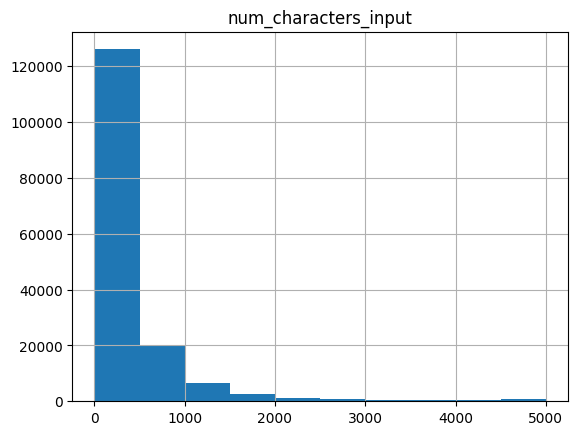

In [ ]:
# number of characters
train["num_characters_input"] = train["comment_text"].apply(lambda x:len(x))
train.hist(column=["num_characters_input"])
average_chars_input = train["num_characters_input"].mean()
print(f"Average number of tokens in the text column: {average_chars_input}")

Classes Count:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
None Class Count: 124473


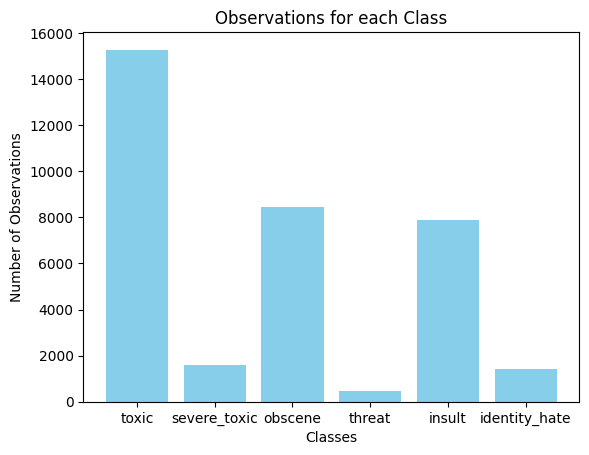

In [ ]:
# classes count
classes_count = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum()
print(f"Classes Count:\n{classes_count}")
print(f"None Class Count: {len(train)-classes_count.sum()}")
plt.bar(classes_count.index, classes_count.values, color="skyblue")
plt.xlabel('Classes')
plt.ylabel("Number of Observations")
plt.title("Observations for each Class")
plt.show()

We can clearly see the imbalance between classes which can be extremely detrimental to the classifier. Therefore, in the next cell, we seperate each class and put them into seperate dataframes. And then sample equal proportion of classes from each dataframe and concat them into one single dataframe to ensure balanced train dataset.

In [ ]:
toxic = train.loc[train["toxic"]==1]
severe_toxic = train.loc[train["severe_toxic"]==1]
obscene = train.loc[train["obscene"]==1]
threat = train.loc[train["insult"]==1]
identity_hate = train.loc[train["identity_hate"]==1]
None_class = train.loc[(train["toxic"]==0)&(train["severe_toxic"]==0)&(train["obscene"]==0)&(train["threat"]==0)&(train["insult"]==0)&(train["identity_hate"]==0)]

print(f"Toxic Count: {len(toxic)}")
print(f"Severe Toxic Count: {len(severe_toxic)}")
print(f"Obscene Count:  {len(obscene)}")
print(f"threat count: {len(threat)}")
print(f"identity hate count: {len(identity_hate)}")
print(f"None class count: {len(None_class)}")

Toxic Count: 15294
Severe Toxic Count: 1595
Obscene Count:  8449
threat count: 7877
identity hate count: 1405
None class count: 143346


In [ ]:
toxic_sample = toxic.head(n=700)
severe_toxic_sample = severe_toxic.head(n=700)
obscene_sample = obscene.head(n=700)
threat_sample = threat.head(n=700)
identity_sample = identity_hate.head(n=700)
none_sample = None_class.head(n=700)

In [ ]:
train_frac = pd.concat([toxic_sample, severe_toxic_sample, obscene_sample, threat_sample, identity_sample, none_sample], axis=0)
len(train_frac)

4200

Average number of tokens in the text column: 381.7609523809524


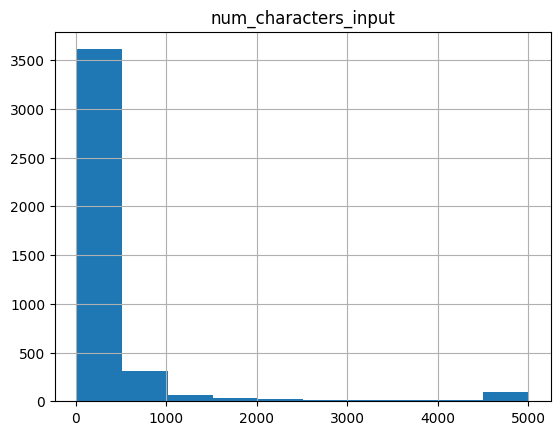

In [ ]:
# characters input
train_frac["num_characters_input"] = train_frac["comment_text"].apply(lambda x:len(x))
train_frac.hist(column=["num_characters_input"])
average_chars_input = train_frac["num_characters_input"].mean()
print(f"Average number of tokens in the text column: {average_chars_input}")

In the above graph we see that most of the input has more than 3500 characters which is large enough for the model to learn semantics of the input and the output.

### **Changing the Ludwig's Encoder-Decoder Input Pipeline Architecture**
Before we move ahead, in the Ludwig's latest documentation, Ludwig officially has text based input for Seq2Seq modelling. However, since our classes are labelled as binary labels, and Ludwig currently only supports one output per model, we have to change the format of the classes in the dataset.

To transform all the binary labels, into one output, we preprocess the binary labels of each class as one single set string under the column "**Label**".

For example, for columns [Toxic, Severe_Toxic, Obscene] if we have the following labels, [0,1,1], then the entire instance will be transformed into "Toxic:0 Severe_Toxic:1 Obscene:1".

This has been done in the above **Preprocessing Section**

However, this creates an issue. Since the encoder-decoder in Ludwig Architecture does not support set text as output, we used the developer API access of Ludwig to alter their architecture as a local contribution.

In the cell below, we will be explaining how to configure the architecture for set-type feature

#### **Explanation of the code below**

**Import Statements** <br>
Here, various modules and classes from the Ludwig library are imported. These imports are necessary for defining and configuring set-type features in machine learning models. They include constants, utility functions, base classes for decoders, encoders, loss functions, and more.

**SetInputFeatureConfigMixin** <br>
This class is a mixin (a way to reuse code) for configuring input features of type "set" in Ludwig. It includes parameters for preprocessing and encoding of set-type features. The @input_mixin_registry.register(SET) decorator registers this mixin for set-type features.

**SetOuputFeatureConfigMixin** <br>
This class is a mixin for configuring output features of type "set" in Ludwig. It includes parameters for the decoder and loss functions of set-type features. The @output_mixin_registry.register(SET) decorator registers this mixin for set-type features.

**SetDefaultConfig** <br>
This class defines the default configuration for set-type features. It inherits from both SetInputFeatureConfigMixin and SetOutputFeatureConfigMixin. The @ecd_defaults_config_registry.register(SET) decorator registers this configuration as the default for set-type features.

**Summary** <br>
this code defines a set of configurations for set-type features in machine learning models using Ludwig. These configurations include settings for input and output features, as well as defaults. Mixins are used to structure and reuse common configurations across different parts of the Ludwig framework. The decorators help register these configurations for specific feature types.

In [ ]:
from ludwig.api_annotations import DeveloperAPI
from ludwig.constants import JACCARD, MODEL_ECD, SET, SIGMOID_CROSS_ENTROPY
from ludwig.schema import utils as schema_utils
from ludwig.schema.decoders.base import BaseDecoderConfig
from ludwig.schema.decoders.utils import DecoderDataclassField
from ludwig.schema.encoders.base import BaseEncoderConfig
from ludwig.schema.encoders.utils import EncoderDataclassField
from ludwig.schema.features.base import BaseInputFeatureConfig, BaseOutputFeatureConfig
from ludwig.schema.features.loss.loss import BaseLossConfig
from ludwig.schema.features.loss.utils import LossDataclassField
from ludwig.schema.features.preprocessing.base import BasePreprocessingConfig
from ludwig.schema.features.preprocessing.utils import PreprocessingDataclassField
from ludwig.schema.features.utils import (
    ecd_defaults_config_registry,
    ecd_input_config_registry,
    ecd_output_config_registry,
    input_mixin_registry,
    output_mixin_registry,
)
from ludwig.schema.metadata import FEATURE_METADATA
from ludwig.schema.metadata.parameter_metadata import INTERNAL_ONLY
from ludwig.schema.utils import BaseMarshmallowConfig, ludwig_dataclass


@DeveloperAPI
@input_mixin_registry.register(SET)
@ludwig_dataclass
class SetInputFeatureConfigMixin(BaseMarshmallowConfig):
    """SetInputFeatureConfigMixin is a dataclass that configures the parameters used in both the set input feature
    and the set global defaults section of the Ludwig Config."""

    preprocessing: BasePreprocessingConfig = PreprocessingDataclassField(feature_type=SET)

    encoder: BaseEncoderConfig = EncoderDataclassField(
        MODEL_ECD,
        feature_type=SET,
        default="embed",
    )


@DeveloperAPI
@ecd_input_config_registry.register(SET)
@ludwig_dataclass
class SetInputFeatureConfig(SetInputFeatureConfigMixin, BaseInputFeatureConfig):
    """SetInputFeatureConfig is a dataclass that configures the parameters used for a set input feature."""

    type: str = schema_utils.ProtectedString(SET)


@DeveloperAPI
@output_mixin_registry.register(SET)
@ludwig_dataclass
class SetOutputFeatureConfigMixin(BaseMarshmallowConfig):
    """SetOutputFeatureConfigMixin is a dataclass that configures the parameters used in both the set output
    feature and the set global defaults section of the Ludwig Config."""

    decoder: BaseDecoderConfig = DecoderDataclassField(
        MODEL_ECD,
        feature_type=SET,
        default="classifier",
    )

    loss: BaseLossConfig = LossDataclassField(
        feature_type=SET,
        default=SIGMOID_CROSS_ENTROPY,
    )


@DeveloperAPI
@ecd_output_config_registry.register(SET)
@ludwig_dataclass
class SetOutputFeatureConfig(SetOutputFeatureConfigMixin, BaseOutputFeatureConfig):
    """SetOutputFeatureConfig is a dataclass that configures the parameters used for a set output feature."""

    type: str = schema_utils.ProtectedString(SET)

    default_validation_metric: str = schema_utils.StringOptions(
        [JACCARD],
        default=JACCARD,
        description="Internal only use parameter: default validation metric for set output feature.",
        parameter_metadata=INTERNAL_ONLY,
    )

    dependencies: list = schema_utils.List(
        default=[],
        description="List of input features that this feature depends on.",
        parameter_metadata=FEATURE_METADATA[SET]["dependencies"],
    )

    preprocessing: BasePreprocessingConfig = PreprocessingDataclassField(feature_type="set_output")

    reduce_dependencies: str = schema_utils.ReductionOptions(
        default="sum",
        description="How to reduce the dependencies of the output feature.",
        parameter_metadata=FEATURE_METADATA[SET]["reduce_dependencies"],
    )

    reduce_input: str = schema_utils.ReductionOptions(
        default="sum",
        description="How to reduce an input that is not a vector, but a matrix or a higher order tensor, on the first "
        "dimension (second if you count the batch dimension)",
        parameter_metadata=FEATURE_METADATA[SET]["reduce_input"],
    )

    threshold: float = schema_utils.FloatRange(
        default=0.5,
        min=0,
        max=1,
        description="The threshold used to convert output probabilities to predictions. Tokens with predicted"
        "probabilities greater than or equal to threshold are predicted to be in the output set (True).",
        parameter_metadata=FEATURE_METADATA[SET]["threshold"],
    )


@DeveloperAPI
@ecd_defaults_config_registry.register(SET)
@ludwig_dataclass
class SetDefaultsConfig(SetInputFeatureConfigMixin, SetOutputFeatureConfigMixin):
    pass

## **Prompt Templating and Zero Shot Inference**

**Zero-shot learning is a capability enabled by Large Language Models, allowing them to generalize to tasks or domains they have never been explicitly trained on.** This approach leverages the inherent knowledge and linguistic understanding encoded within the model during its pretraining phase.

Zero-shot learning involves presenting the model with a task description or prompt, along with some context, and expecting it to generate a relevant response or output. The key idea is that the model can understand and generate coherent content even for tasks it hasn't been explicitly fine-tuned for.

<img src="https://ludwig.ai/latest/images/icl_zero_shot_learning.png" alt="ICL" width="650"/>

In Ludwig, there are two parameters we can use to control prompting and the quality of generation when trying to use the LLM for zero-shot inference:
- `prompt`: the prompt parameter can be used to
  - Provide necessary boilerplate needed to make the LLM respond in the correct way (for example, with a response to a question rather than a continuation of the input sequence).
  - Combine multiple columns from a dataset into a single text input feature.
  - Provide additional context to the model that can help it understand the task, or provide restrictions to prevent hallucinations (producing false information confidently). <br>

  All of this can be configured through the nested keyword called `template`. The template allows regular text to describe the task, but also allows two special group of keywords that can be used:
  - **Reserved Keywords**: `{__sample__}`, `{__task__}` and `{__context__}`
  - **Feature Names**: If you have additional feature names you want to combine into your prompt, you can add them using the same `{}` template without the `__`. For e.g., in our case, we have three columns: `instruction`, `input` and `output`. We can refer to the `instruction` and `input` data via the `{instruction}` and `{input}`. We will see this in our example below.


- `generation`: You may often want to control the generation process, such as what token decoding strategy to use, how many new tokens to produce, which tokens to exclude, or how diverse you want the generated text to be.

Let's try and perform some zero-shot prompting with Ludwig to see how the model does on our task out of the box.

In [ ]:
zero_shot_config = yaml.safe_load(
    '''
   model_type: llm
   base_model: 'meta-llama/Llama-2-7b-hf'

   input_features:
     - name: Instructions
       type: text

   output_features:
     - name: labels
       type: text

   prompt:
     template: >-
       Below is an instruction that describes a task, paired with an input
       that may provide further context. Write a response that appropriately
       completes the request.
       ### Instruction: {Instructions}

       ### Input: {comment_text}

       ### Response:

   generation:
     temperature: 0.1 # Temperature is used to control the randomness of predictions.
     max_new_tokens: 512

   preprocessing:
     split:
       type: fixed

   quantization:
     bits: 4
   '''
)

model = LudwigModel(config=zero_shot_config, logging_level=logging.INFO)
results = model.train(dataset=train[:10])

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'None': 342 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 344 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 344 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'labels': 28 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 30 (including start and stop symbols)
INFO:ludwig.features

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

INFO:ludwig.models.llm:Done.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.trainers.trainer_llm:
Running evaluation for step: 0, epoch: 0
INFO:ludwig.trainers.trainer_llm:Evaluation took 0.1951s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │ train   │ validation   │ test   │
╞═══════════════╪═════════╪══════════════╪════════╡
│ combined_loss │         │              │        │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.models.llm:Skipped saving LLM without weight adjustments.
INFO:ludwig.models.llm:Skipped saving LLM without weight adjustments.
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ 

#### **Observations From Zero Shot Prompting Results**
1. The base Llama-2 model is generally good at producing coherent English text as responses.
2. When it doesn't know how to respond (which seems to be true most of the times we want it to follow an instruction), it just returns the input over and over again until the token limit is reached. Sometimes it even modifies the original instruction in the process.
3. It doesn't know when to stop producing a response, i.e., it gets confused and just produces till we set a hard stop through the number of maximum allowed tokens. In an ideal scenario, the probability distribution being used to generate the next token predicts a stop token at the right point in time.
4. It doesn't get even one of the input prompts correct.
**None of these results are surprising, but it goes to show that while a model like Llama-2 can be good on general tasks, it can often be very poor at performing domain specific tasks out of the box just through zero shot/regular prompting (pretrained knowledge without any additional context)**

# **Declaratively Fine-Tune Large Language Models**

Fine-tuning a large language model **refers to the process of further training the pre-trained model on a specific task or domain using a smaller dataset.** The initial pre-training phase involves training a language model on a massive corpus of text data to learn general language patterns and representations. Fine-tuning, on the other hand, customizes the model to a specific task or domain by exposing it to task-specific data. By fine-tuning a large language model on a specific task, you leverage the pre-trained knowledge of the model while tailoring it to the nuances and requirements of your target task. This typically allows the model to perform better and achieve higher accuracy on the specific task compared to using the pretrained model by itself for your specific task.

#### ▶ **What is instruction following/tuning? Why should I do it?**

Pre-trained language models are often great at giving general answers, but they struggle when asked to follow specific instructions, especially for tasks in certain domains. To make a pre-trained model do better at these specific tasks, we can train it on examples of those tasks. This is called instruction fine-tuning. We use a dataset with pairs of `{instructions, outputs}` in the domain, and this helps the model learn to give the right response when given those types of instructions. This training process typically changes the underlying model weights, but there are also other ways to train it without doing this. When done correctly, this process teaches the model to understand and follow instructions it couldn't handle well before.


The base model does not know how to follow-instructions and answer the question for our task, so just repeats the inputs we passed in until the token limit is hit. Our fine-tuned model should be able to respond back correctly (these are actual outputs from a model we fine-tuned).


There are three different fine-tuning approaches in Ludwig:

1. **Full Fine-Tuning**:

- Involves training the entire pre-trained model on new data from scratch.
- All model layers and parameters are updated during fine-tuning.
- Can lead to high accuracy but requires a significant amount of computational resources and time.
- Runs the risk of catastrophic forgetting: occasionally, since we are updating all of the weights in the model, this process can lead to the algorithm inadvertently losing knowledge of its past tasks, i.e., the knowledge it gained during pretraining. The outcome may vary, with the algorithm experiencing heightened error margins in some cases, while in others, it might completely erase the memory of a specific task leading to terrible performance.
- Best suited when the target task is significantly different from the original pre-training task.

2. **Parameter Efficient Fine-Tuning (PEFT), e.g. LoRA**:

- Focuses on updating only a subset of the model's parameters.
- Often involves freezing certain layers or parts of the model to avoid catastrophic forgetting, or inserting additional layers that are trainable while keeping the original model's weights frozen.
- Can result in faster fine-tuning with fewer computational resources, but might sacrifice some accuracy compared to full fine-tuning.
- Includes methods like LoRA, AdaLoRA and Adaption Prompt (LLaMA Adapter)
- Suitable when the new task shares similarities with the original pre-training task.

3. **Quantization-Based Fine-Tuning (QLoRA)**:

- Involves reducing the precision of model parameters (e.g., converting 32-bit floating-point values to 8-bit or 4-bit integers). This reduces the amount of CPU and GPU memory required by either 4x if using 8-bit integers, or 8x if using 4-bit integers.
- Typically, since we're changing the weights to 8 or 4 bit integers, we will lose some precision/performance.
- This can lead to reduced memory usage and faster inference on hardware with reduced precision support.
- Particularly useful when deploying models on resource-constrained devices, such as mobile phones or edge devices.


**Today, we're going to fine-tune using method 3 since we only have access to a single T4 GPU with 16GiB of GPU VRAM on Colab.** If you have more compute available, give LoRA based fine-tuning or full fine-tuning a try! Typically this requires 4 GPUs with 24GiB of GPU VRAM on a single node multi-GPU cluster and fine-tuning Deepspeeed.


To do this, the new parameters we're introducing are:

- `adapter`: The PEFT method we want to use
- `quantization`: Load the weights in int4 or int8 to reduce memory overhead.
- `trainer`: We enable the `finetune` trainer and can configure a variety of training parameters such as epochs and learning rate.

Note, there are a few additional preprocessing parameters we should set to ensure that training runs smoothly:

```yaml
preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 1
    - 0
    - 0
```

Some of the examples in the dataset have long sequences, so we set a `global_max_sequence_length` of 512 to ensure that we do not OOM.

We also use 100% of data for training as the evaluation phase takes extra time and we will predict on new examples right afterwards.

We have defined `learning_rate = 0.0004` which is an experimental value obtained from regular training. In our case, the the gradient at which the loss function is minimized is achieved without the divergence of gradients from one point to another.

We also define `warmup_fraction=0.03` which ensures that with learning rate, the gradient does not move alot at the start of training model until the model is stabilized. This mitigates the problem of exploding or vanishing gradients

In [ ]:
qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: meta-llama/Llama-2-7b-hf

input_features:
  - name: Instructions
    type: text

output_features:
  - name: labels
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.
    ### Instruction: {Instructions}

    ### Input: {comment_text}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 1
    - 0
    - 0

trainer:
  type: finetune
  epochs: 1
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=train_frac)

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'None': 2645 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 2647 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 2647 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'labels': 28 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 30 (including start and stop symbols)
INFO:ludwig.featu

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

INFO:ludwig.models.llm:Done.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 4200 step(s), approximately 1 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 21000 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:  11%|█         | 448/4200 [06:31<1:02:22,  1.00it/s, loss=nan]

/usr/local/lib/python3.10/dist-packages/torchmetrics/aggregation.py:77: UserWarning: Encounted `nan` values in tensor. Will be removed.
  warnings.warn("Encounted `nan` values in tensor. Will be removed.", UserWarning)


Training: 100%|██████████| 4200/4200 [1:01:15<00:00,  1.24it/s, loss=0.00414]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 4200, epoch: 0
INFO:ludwig.trainers.trainer:Evaluation took 0.5722s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════╕
│                       │      train │ validation   │ test   │
╞═══════════════════════╪════════════╪══════════════╪════════╡
│ bleu                  │     0.0332 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ char_error_rate       │     7.7497 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ loss                  │     0.1444 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ next_token_perplexity │ 12360.0576 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ perplexity            │ 32001.4082 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ rouge1_fmea

Training: 100%|██████████| 4200/4200 [1:01:16<00:00,  1.14it/s, loss=0.00414]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ FINISHED │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


### **Testing Predictions**

#### **Balancing Classes in the Test Dataset for Classification Report**

To balance each class to some extent, we will be sampling 50 instances from each class dataframe stored previous in the notebook earlier. The total number of instances in test will be 300 Instances. We will not be testing it on the entire dataset since we have a high chance of running into OOM error because of limited GPU.

In [ ]:
toxic_test_x = toxic.iloc[800:850,:][["comment_text"]]
severe_test_x = severe_toxic.iloc[800:850,:][["comment_text"]]
obscene_test_x = obscene.iloc[800:850,:][["comment_text"]]
threat_test_x = threat.iloc[800:850,:][["comment_text"]]
identity_test_x = identity_hate.iloc[800:850,:][["comment_text"]]
none_test_x = None_class.iloc[800:850,:][["comment_text"]]

toxic_test_y = toxic.iloc[800:850,1:7]
severe_test_y = severe_toxic.iloc[800:850,1:7]
obscene_test_y = obscene.iloc[800:850,1:7]
threat_test_y = threat.iloc[800:850,1:7]
identity_test_y = identity_hate.iloc[800:850,1:7]
none_test_y = None_class.iloc[800:850,1:7]

In [ ]:
test_y = pd.concat([toxic_test_y, severe_test_y, obscene_test_y, threat_test_y, identity_test_y, none_test_y], axis=0)
test_x = pd.concat([toxic_test_x, severe_test_x, obscene_test_x, threat_test_x, identity_test_x, none_test_x], axis=0)

In [ ]:
test_x["Instructions"] = '''Recognize the Sentiment Polarity of the Class. Given the classes determine whether the text belongs to the class or not.
If the text belongs to the class assign the class 1 else 0. Here are the classes: [Toxic, Severely Toxic, Obscene, Threat, Insult, Identity Hate].
Answer Format:
Toxic: class_value
Severely Toxic: class_value
Obscene: class_value
Threat: class_value
Insult: class_value
Identity Hate: class_value'''
test_x["split"]=1
test_x.head(3)

,comment_text,Instructions,split
8035,"SEZ YOU, YOU ANNOYING EDITOR!",Recognize the Sentiment Polarity of the Class....,1
8040,i think you'll find you are edit waring too so...,Recognize the Sentiment Polarity of the Class....,1
8050,"Hey white person, you suck. Stop being so whit...",Recognize the Sentiment Polarity of the Class....,1


In [ ]:
print(f"Test Size: {len(test_x)}")

Test Size: 300


#### **Batch-wise implementation for prediction to avoid OOM Error**

In [ ]:
batch_size = 50
num_batches = len(test_x) // batch_size

predictions = pd.DataFrame()

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_predictions = model.predict(test_x[start_idx:end_idx])[0]
    predictions = pd.concat([predictions, batch_predictions])

predictions

#### **Predictions**

In [ ]:
labels = predictions["labels_response"]

In the cell below, since we have set max_token=512, we would keep track of responses that were not fully generated and append their index to the truncated_list variable to remove them in later cells.

In [ ]:
toxic_labels = []
severe_toxic_labels = []
obscene_labels = []
threat_labels = []
insult_labels = []
identity_hate_labels = []
truncated_index = []
for index, label in enumerate(labels):
  split = label[0].split(":")
  if len(split)==7:
    toxic_labels.append(int(split[1][0]))
    severe_toxic_labels.append(int(split[2][0]))
    obscene_labels.append(int(split[3][0]))
    threat_labels.append(int(split[4][0]))
    insult_labels.append(int(split[5][0]))
    identity_hate_labels.append(int(split[6][0]))
  else:
    truncated_index.append(index)

In [ ]:
len(toxic_labels)==len(severe_toxic_labels)==len(obscene_labels)==len(threat_labels)==len(insult_labels)==len(identity_hate_labels)

True

In [ ]:
predictions = pd.DataFrame({"toxic":toxic_labels,
                            "severe_toxic":severe_toxic_labels,
                            "obscene":obscene_labels,
                            "threat":threat_labels,
                            "insult":insult_labels,
                            "identity_hate":identity_hate_labels})
predictions.head(2)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,0,0,0,1,0
1,1,1,1,0,1,0


In [ ]:
truncated_index

[101]

In [ ]:
# dropping truncated responses.
test_y.reset_index(inplace=True, drop=True)
test_y.drop(101, inplace=True)
test_y

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,0,0,0,0,0
1,1,0,1,0,1,0
2,1,0,1,0,1,1
3,1,0,1,0,1,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
295,0,0,0,0,0,0
296,0,0,0,0,0,0
297,0,0,0,0,0,0
298,0,0,0,0,0,0


### **Classification Report (Final Results)**
In this classification report, we generate a classification matrix for multi-label classification problem. Due to extreme imbalance of classes and total characters in each input, we will be using precision and recall of each class and macro-average f1 score to evaluate our model

In [ ]:

# Flatten the DataFrames for classification metrics
y_true_flat = test_y
y_pred_flat = predictions

# Calculate precision, accuracy, and F1 score for each class
precision_per_class = precision_score(y_true_flat, y_pred_flat, average=None)
accuracy = accuracy_score(y_true_flat, y_pred_flat)
f1_per_class = f1_score(y_true_flat, y_pred_flat, average=None)
recall_per_class = recall_score(test_y, predictions, average=None)


# Calculate precision, accuracy, and F1 score for all classes (macro-averaged)
precision_macro = precision_score(y_true_flat, y_pred_flat, average='macro')
f1_macro = f1_score(y_true_flat, y_pred_flat, average='macro')

# Print the results
print("Recall per class:")
print(recall_per_class)

print("Precision per class:")
print(precision_per_class)

print("\nF1 score per class:")
print(f1_per_class)

print("\nMacro-averaged Precision:")
print(precision_macro)

print("\nMacro-averaged F1 score:")
print(f1_macro)

# Classification report for detailed metrics
classification_rep = classification_report(y_true_flat, y_pred_flat)
print("\nClassification Report:")
print(classification_rep)

Recall per class:
[1.         0.92771084 0.97948718 0.44444444 0.98445596 0.93333333]
Precision per class:
[0.91254753 0.53846154 0.89671362 0.30769231 0.79497908 0.66666667]

F1 score per class:
[0.95427435 0.68141593 0.93627451 0.36363636 0.87962963 0.77777778]

Macro-averaged Precision:
0.6861767893098342

Macro-averaged F1 score:
0.7655014273213286

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       240
           1       0.54      0.93      0.68        83
           2       0.90      0.98      0.94       195
           3       0.31      0.44      0.36         9
           4       0.79      0.98      0.88       193
           5       0.67      0.93      0.78        75

   micro avg       0.79      0.97      0.87       795
   macro avg       0.69      0.88      0.77       795
weighted avg       0.81      0.97      0.88       795
 samples avg       0.67      0.81      0.72       795



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Improvements on the model**

- **Handling Class Imbalance:**
  - Implement weighted loss functions: Assign higher weights to underrepresented classes during training to mitigate the impact of class imbalance.
  - Explore advanced sampling techniques: Employ methods like oversampling or undersampling to ensure a more balanced representation of classes in the training data.

- **Optimizing Storage for GPU and RAM:**
  - Utilize model quantization techniques: Reduce the precision of model weights to compress the model, minimizing GPU and RAM storage requirements without compromising performance significantly.
  - Explore model distillation: Train a smaller model to replicate the behavior of the larger LLM, reducing the memory footprint while preserving essential knowledge.

- **Prompt Engineering:**
  - Refine and diversify prompts: Systematically experiment with prompts to elicit desired behaviors from the LLM, considering variations in language and context to improve model response across diverse inputs.
  - Leverage prompt tuning: Iteratively fine-tune prompts based on model performance, adapting them to address specific tasks or domains effectively.

- **Data Augmentation Techniques:**
  - Explore text augmentation: Introduce variations in training data through techniques like synonym replacement, paraphrasing, or random word insertion, enhancing the model's ability to handle diverse inputs.
  - Implement contextual augmentation: Augment data with contextually relevant information to improve the model's adaptability to nuanced scenarios.

- **Regularization Strategies:**
  - Introduce dropout layers: Incorporate dropout layers during fine-tuning to prevent overfitting and enhance the model's generalization capabilities.
  - Experiment with L2 regularization: Apply L2 regularization to the model's weights to control complexity and promote better generalization.

- **Transfer Learning Approaches:**
  - Investigate domain-specific pre-training: Pre-train LLMs on datasets relevant to the target domain before fine-tuning, enhancing the model's task-specific knowledge.
  - Utilize multi-task learning: Fine-tune LLMs on multiple related tasks simultaneously to encourage shared learning and improve overall model performance.

These strategies collectively aim to address challenges associated with class imbalance, resource constraints, prompt effectiveness, and data diversity, fostering the continuous improvement of fine-tuning processes for Large Language Models.



# **End-of-NoteBook**